## Explorative search, graph-based discovery of text documents

This notebook introduces a document-word graph-based search technique that leverages NLP and Pagerank, to allow you to explore text collections and discover unexpected relations between them. At the end, we get a way to retrieve documents related to a keyword, or that share words similar to other documents. 

### Introduction

Imagine you have a collection of text documents, and you want to retrieve those which are related to a keyword. A rule of thumb would be : type a keyword, get me all the documents that have this keyword in their text. To rank those results by "relevance", classical techniques, such as [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25), are based around Term Frequency (how much the keyword is present in the document) and Inverse Document Frequency (how rare and specific the keyword is). Documents where the keyword is frequent are ranked higher than those where it's not.

**The traditional techniques works well if you know exactly what you are looking for. But if you don't, they fall appart.**  

This is especially the case when dealing with a large knowledge base, where you don't really know what's inside. Instead of looking up for a perticular document, you usually want to just explore the collection, discover interesting relations, or get a better undersanding of the knowledge base. For example, by searching for the keyword "yoghourt", you'd actually be interested in learning about "milk industry", "agricultural sector", "rural areas", and other stuff loosely related to yoghourt.

The technique I introduce here helps you discover a text-based knowledge base by leveraging a document-word graph representation of the document collection. 

### Data 

We will be working with a dataset of ABC news headlines (Austalian Broadcasting Corporation). Thanks to Rohit Kulkarni for [sharing this dataset on Kaggle](https://www.kaggle.com/therohk/million-headlines). There are more than a million headlines in this dataset. 

In [1]:
import pandas as pd

df = pd.read_csv("data/abcnews-date-text.csv")
print(f"Number of documents: {df.shape[0]}")

Number of documents: 1186018


## Creating a graph out of text

A bag-of-word embedding is a vector representation of text, where each row is a document and each column is a word. In its simplest form, if a word is in a document, then there is a 1 in the cell. Otherwise, there is 0. 

For a corpus of text, this representation can be interpretated as a bigraph adjacency matrix. That is, the mathematical encoding of a graph, where documents are linked to each other through shared words. This is called a document-word graph.

Below, on the left, you have 30 random article headlines. On the right, they are connected to words. You can jump from an article to another by following their common words. 

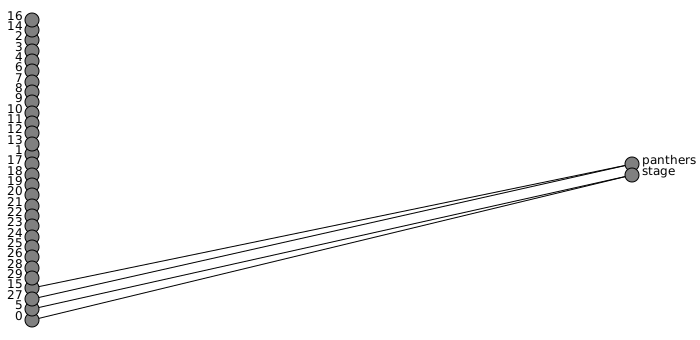

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sknetwork.visualization import svg_bigraph
from IPython.display import SVG

nb_sub_samples = 30
stop_words = ["I", "the", "he", "she", "it", "is", "of", "to", "in", "his", "her", "their", "its", "a", "out", "of", "on", "up", "with", "for", "at", "should", "not", "is", "as", "no"]
small_df = df.sample(nb_sub_samples)

count_2 = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
small_adjacency = count_2.fit_transform(small_df["headline_text"])
reverse_vocab = {v: k for k, v in count_2.vocabulary_.items()}
names_col = [reverse_vocab[i] for i in range(len(reverse_vocab))]
names_row = list(range(nb_sub_samples))

image = svg_bigraph(small_adjacency, names_row=names_row, names_col=names_col, width=600)
SVG(image)

Let's now do this on the full dataset. Since it's so big, we won't be showing the graph. Note that this graph only needs to be computed once. 

In [3]:
%%time 

count = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
adjacency = count.fit_transform(df['headline_text'])
print("Shape of the full adjacency matrix:", adjacency.shape)
print("Number of non-zero elements:", adjacency.nnz)

Shape of the full adjacency matrix: (1186018, 62187)
Number of non-zero elements: 6670374
CPU times: user 13.3 s, sys: 262 ms, total: 13.6 s
Wall time: 13.7 s


## Using PageRank to search through documents

We are going to use a variant of PageRank algorithm on this adjacency matrix. 

### The PageRank algorithm

PageRank is an algorithm developed by Google in 2000s to find relevant websites based on their URL links. At the time, websites at the top of Google seach were those who were the most linked to, and by websites that were also the most linked to. This ranking of websites is made by averaging several random walks on the graph of website to website links. 

Imagine robots following randomly links on webpages, and keeping a record on which websites they end up most often : those would be at the top of the search results. Markov chain theory guarantees us that this algorithm converges towards a unique ranking. 

BiPageRank is the same idea, but applied to bigraphs. The algorithm performs a random walk from an article, to a word, to another article, to a word, and so on. 

Computationally, this random walk is nothing more than matrix multiplications. 

### Personalized PageRank

The variant we will be using is called Personalized BiPageRank. Basically, instead of starting our random walk anywhere on the graph, we make it start on a specific node of the graph. To get search results relevant to a word, we will be starting our random walk on this word's node. 

In [4]:
from sknetwork.ranking import BiPageRank, top_k

bpr = BiPageRank()
scores = bpr.fit_transform(adjacency, seeds_col={count.vocabulary_["threat"]:1})

for rank, (i, row) in enumerate(df.iloc[top_k(scores, 10)].iterrows()):
    print(f"{rank+1}: {row['headline_text']}")

1: tsunami threat overhyped
2: tunbridge dam leak threat eases
3: mccrae residents face fire threat
4: mccrae grassfire no longer a threat
5: sandery death threat misunderstanding killa nickname
6: patient blacklisting threat symptomatic of
7: wanilla fire threat eases
8: kinkuna homes threat of bushfire
9: pichi richi marathon under threat
10: jo goodhew milk threat


We can also do it by starting on an article's node. This acts as a recommendation of "similar articles". The article we look at is "more women urged to become councillors". It yields us articles about various urges over councillors.

In [7]:
scores = bpr.fit_transform(adjacency, seeds_row={100:1})

for rank, (i, row) in enumerate(df.iloc[top_k(scores, 10)].iterrows()):
    print(f"{rank+1} (idx: {i}) : {row['headline_text']}")

1 (idx: 100) : more women urged to become councillors
2 (idx: 182223) : push on for more women councillors
3 (idx: 883878) : councillors urged to back more wholistic way to
4 (idx: 107383) : blokes chauvinism dudding potential councillors
5 (idx: 372296) : new councillors urged to quickly grasp issues
6 (idx: 876874) : councillors urged to back old castlemaine gaol
7 (idx: 659286) : lake councillors urged to reject biodiversity offsets policy
8 (idx: 450766) : lake wooloweyah subdivision divides councillors
9 (idx: 1026213) : perth councillors urged not to criticise lord mayor scaffidi
10 (idx: 43461) : councillors urged to consider roles during


We can also start from several nodes, both articles and words, to perform complex searches. For example, let's look at articles similar to "more women urged to become councillors", but also to "police" and "fire". The third result is about a man charged (i.e. arrested by the *police*) after setting a *fire* in *councillors* office : very relevant to our bizarre search query. 

In [10]:
%%time
scores = bpr.fit_transform(adjacency, seeds_row={100:1}, seeds_col={count.vocabulary_["police"]:1, count.vocabulary_["fire"]:1})

for rank, (i, row) in enumerate(df.iloc[top_k(scores, 20)].iterrows()):
    print(f"{rank+1} (idx: {i}) : {row['headline_text']}")

1 (idx: 100) : more women urged to become councillors
2 (idx: 189645) : councillors under fire after pay rise
3 (idx: 767815) : man charged over brisbane councillors office fire
4 (idx: 126586) : councillors under fire over adult entertainment
5 (idx: 125656) : councillors want no fire ban exemptions
6 (idx: 636501) : no show councillors under fire
7 (idx: 182223) : push on for more women councillors
8 (idx: 883878) : councillors urged to back more wholistic way to
9 (idx: 279629) : police meet councillors over noble park hoons
10 (idx: 979367) : bendigo councillors escorted by police
11 (idx: 958551) : dungog councillors urged to act on storm damage in aged care un
12 (idx: 372296) : new councillors urged to quickly grasp issues
13 (idx: 876874) : councillors urged to back old castlemaine gaol
14 (idx: 107383) : blokes chauvinism dudding potential councillors
15 (idx: 940414) : councillors urged to approve bendigo hotel pokies
16 (idx: 1026213) : perth councillors urged not to critici

## Tinkering with the graph

Quality and relevancy of search results heavily depends on the quality of the underlying graph. 



### Lower the word quantity

According to my experience, this search technique works best with short documents. The idea is that signal-to-noise ratio is high: with too many parasit words, you'll have less relevant results. But also, the algorithm is much faster with a sparse and small graph. In that sense, rare and meaningful links are great. 

#### Stemming and lemmatization

These are two NLP techniques that clean up the text before building the graph. 
- **[Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)** : remove the varying end of words. Ex: liking, likely, liked, likes => like 
- **[Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)** : get back to the root of the word. Ex: better => good, rocks => rock, maxima => maximum

This way, singular and plurals become the same tokens (words).

Even though you only need to do it once for each document, lemmatization is costly. It needs to understand the role of each word in a sentence (noun, verb, adjective, etc.). In this notebook, we will perform it only on a susbsample of 30,000 documents. 

In [23]:
%%time
import spacy

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization takes a long time, because it needs to guess the role of each word in a sentence
# We will do it on a subsample of our dataset

df_small = df.sample(30000)

def lemmatize(sentence):
    # Apply lemmatization to each word in a sentence
    return [token.lemma_ for token in nlp(sentence)]

df_small['cleaned_text'] = df_small["headline_text"].map(lambda x: lemmatize(x))

CPU times: user 1min 25s, sys: 355 ms, total: 1min 25s
Wall time: 1min 26s


In [24]:
# We already tokenized our text in the previous step, so we change our preprocessor and tokenizer to a dummy function
def dummy(x):
    return x

count_lem = CountVectorizer(min_df=2, binary=True, stop_words=stop_words, preprocessor=dummy, tokenizer=dummy, token_pattern=None)
adjacency_small_lem = count_lem.fit_transform(df_small["cleaned_text"].to_list())

# We will also compare the results to the method without lemmatization
count_small = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
adjacency_small = count_small.fit_transform(df_small["headline_text"])

With lemmatization, we have ~20% less tokens. Since PageRank works by doing matrix multiplication, at scale, this could be a huge improvement in inference time. 

In [25]:
print(f"Without lemmatization: {len(count_small.vocabulary_)} tokens.")
print(f"With lemmatization: {len(count_lem.vocabulary_)} tokens.")

Without lemmatization: 11691 tokens.
With lemmatization: 9393 tokens.


We run the algorithm on a query example : articles similar to "olympic swimmer sweating on fight probe". 

Without lemmatization, the explorative search algorithm ranks higher articles with the exact word "sweating", such as "johnson clark still sweating on decision". 

In [39]:
%%time
# Without lemmatization
scores = bpr.fit_transform(adjacency_small, seeds_row={1000:1})

for rank, (i, row) in enumerate(df_small.iloc[top_k(scores, 10)].iterrows()):
    print(f"{rank+1} (idx: {i}) : {row['headline_text']}")

1 (idx: 373411) : olympic swimmer sweating on fight probe
2 (idx: 269270) : johnson clark still sweating on decision
3 (idx: 832030) : indefinite suspension for olympic champion swimmer sun yang
4 (idx: 887430) : swimmer allegedly abused by volkers insulted by prosecutor
5 (idx: 888323) : swimmer heads to glasgow inspired by olympics great aunt
6 (idx: 1056047) : 91yo swimmer ready for masters games gold coast
7 (idx: 924912) : police concerned for missing swimmer murrumbidgee river
8 (idx: 1068448) : former gold medal swimmer bec creedy eyes ironwoman crown
9 (idx: 427713) : police divers to join search for missing swimmer
10 (idx: 505798) : swimmer molested by leading coach
CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 162 ms


With lemmatization, the explorative search algorithm ranks higher articles which have any form of the verb "sweat" : sweating, sweat, sweats... This is because all of these form are, in lemmatized form, the same token. 

In [38]:
%%time
# With lemmatization
scores = bpr.fit_transform(adjacency_small_lem, seeds_row={1000:1})

for rank, (i, row) in enumerate(df_small.iloc[top_k(scores, 10)].iterrows()):
    print(f"{rank+1} (idx: {i}) : {row['headline_text']}")

1 (idx: 373411) : olympic swimmer sweating on fight probe
2 (idx: 821590) : roosters sweat on johnston for sanfl prelim
3 (idx: 269270) : johnson clark still sweating on decision
4 (idx: 1156803) : timber industry sweats on future
5 (idx: 815830) : murray turns up heat as us open sweats
6 (idx: 832030) : indefinite suspension for olympic champion swimmer sun yang
7 (idx: 888323) : swimmer heads to glasgow inspired by olympics great aunt
8 (idx: 681462) : more aussie swimmers bound for olympics
9 (idx: 566963) : disabled swimmers deserve bigger presence cowdrey
10 (idx: 887430) : swimmer allegedly abused by volkers insulted by prosecutor
CPU times: user 140 ms, sys: 149 µs, total: 140 ms
Wall time: 177 ms


#### Keywords summary

If you have long documents, summing them up to their keywords will allow you to efficiently shorten them. There are different techniques to do so. To stay in theme, I'll show you two graph-based ones. 

1. co occurence matrix : document by document.

https://cran.r-project.org/web/packages/textrank/vignettes/textrank.html

2. co occurence matrix : whole dataset. Keep top 1000 keywords for example. Summarize each doc by the less frequent keyword first.

co occurrence matrix + pagerank -> keyword list. Use as vocab

```
from sklearn.feature_extraction.text import CountVectorizer
docs = ['this this this book',
        'this cat good',
        'cat good shit']
count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model
X = count_model.fit_transform(docs)
# X[X > 0] = 1 # run this line if you don't want extra within-text cooccurence (see below)
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
print(Xc.todense()) # print out matrix in dense format
```

Other method :

https://pypi.org/project/rake-nltk/

Note that stop words are also super useful. 

### Vary words' importance

Not all links matter the same. In the same spirit as keywords, you want to lower impact of common words, and increase impact of rare words.

This is where IDF (Inverse Document Frequency) can come useful. Note that IDF was used in the traditional search algorithm [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25). We're getting the best of both worlds. 

todo: TF-IDF + threshold

## Using other metadata to link documents

We are building a graph linking document to each other. But links don't have to only be words. Typically, you'd want to use metadata : tags, categories, dates, shared followers or subscribers... 

TODO : link documents by month+year



### References

- [Using Combined Document-Word Graphsfor Wikipedia Search](https://west.uni-koblenz.de/assets/theses/bachelorsthesis_elias_zervudakis_and_felix_engelmann.pdf), bachelor's thesis by Felix Engelmann and Elias Zervudakis. Same idea as this notebook, but they apply it on Wikipedia articles and evaluate search relevancy with user feedback. 

### Special thanks 

Thanks to Thomas Bonald, my teacher at Télécom Paris, for developing the amazing [scikit-network library](https://scikit-network.readthedocs.io/en/latest/index.html) to handle graphs and for opening me to the world of graphs.

Thanks to [Foundamental](https://foundamental.com/), the company where I did an internship, and gave me the opportunity to experiment these ideas freely and giving me feedback on prototypes. 